Notebook objective: Tune & test GPBoost model with LGBM booster and a random intercept for store_id.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna

from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import gpboost as gpb

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Set print options
np.set_printoptions(suppress=True, precision=6, edgeitems = 7)
pd.options.display.float_format = '{:.6f}'.format
pd.set_option('display.max_columns', None)

# Preprocessing

In [3]:
random_state = 1923

In [4]:
# Read data
df = pd.read_csv("./InputData/full_data.csv")

In [5]:
# Reindex data from 0:N
df = df.reset_index(drop = True)

In [6]:
# Drop rows with too high duration
high_end = 10800 # 3 hours
df = df[df["duration"] <= high_end]

In [7]:
# Split features & target, drop non-feature columns
X = df.drop(["created_at", "actual_delivery_time", "duration"], axis = 1)
y = df.duration

In [8]:
# Split features & group variables
G = X["store_id"]
X = X.drop(["store_id"], axis = 1)

In [9]:
# Enforce dtype of group variables
G = G.astype("str") 

In [10]:
train_end = int(len(df) * 0.6)

In [11]:
val_end = train_end + int(len(df) * 0.2)

In [12]:
# Train - val - test split, 60 - 20 - 20
X_train, X_val, X_test = X[:train_end], X[train_end:val_end], X[val_end:]
G_train, G_val, G_test = G[:train_end], G[train_end:val_end], G[val_end:]
y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]

In [13]:
# Target encoder for non-group categoricals, without hierarchy
encoder = TargetEncoder(cols = ["market_id", "order_protocol", "store_primary_category"])

In [14]:
# Preprocess data
X_train = encoder.fit_transform(X_train, y_train)
X_val = encoder.transform(X_val)
X_test = encoder.transform(X_test)

# Hyperparameter tuning

In [18]:
# Objective function
def objective_gpb(trial):

    # Define hyperparameter space
    learning_rate = trial.suggest_float("learning_rate", 0.05, 0.5)
    num_leaves = trial.suggest_int("num_leaves", 2**2, 2**10)
    #max_depth = trial.suggest_int("max_depth", 2, 20) # Max depth of 20 is too restrictive for LightGBM
    min_child_samples = trial.suggest_int("min_child_samples", 10, 1000, log = True)
    min_child_weight = trial.suggest_float("min_child_weight", 0.001, 20, log = True)
    reg_alpha = trial.suggest_float("l1_reg", 0, 1)
    reg_lambda = trial.suggest_float("l2_reg", 0, 2)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.25, 1)

    # Create model
    #callbacks = [gpb.early_stopping(50)]
    
    model = gpb.GPBoostRegressor(
        n_jobs = 10,
        #device_type = "gpu",
        n_estimators = 5000,
        num_leaves = num_leaves,
        random_state = random_state,
        #max_depth = max_depth,
        max_depth = -1,
        min_child_samples = min_child_samples,
        learning_rate = learning_rate,
        min_child_weight = min_child_weight,
        reg_alpha = reg_alpha,
        reg_lambda = reg_lambda,
        colsample_bytree = colsample_bytree
    )

    # Create random effects model
    gp_model = gpb.GPModel(
        group_data = G_train, # Random intercepts for each group
        likelihood = "gaussian",
        seed = random_state
    )
    gp_model.set_prediction_data(group_data_pred = G_val)

    # Train model with early stopping
    model.fit(
        X_train, 
        y_train,
        gp_model = gp_model, 
        eval_set = [(X_val, y_val)],
        early_stopping_rounds = 50,
        #callbacks = callbacks,
        verbose = False)

    # Report best number of rounds
    trial.set_user_attr("n_rounds", (model.best_iteration_ + 1))
    
    return model.best_score_['valid_0']['l2']


In [19]:
# Create study
study_gpb = optuna.create_study(
  sampler = optuna.samplers.TPESampler(seed = random_state),
  study_name = "tune_gpb",
  direction = "minimize"
)

In [ ]:
# Perform study
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_gpb.optimize(
  objective_gpb, 
  n_trials = 1000,
  show_progress_bar = True)

In [21]:
# Save tuning log
trials_gpb = study_gpb.trials_dataframe().sort_values("value", ascending = True)
trials_gpb.to_csv("./ModifiedData/trials_gpb1.csv", index = False)

# Testing & diagnostics

In [15]:
# Load best tune
best_tune = pd.read_csv("./ModifiedData/trials_gpb1.csv").iloc[0]

In [16]:
best_tune

number                                             282
value                                    887483.424186
datetime_start              2023-11-30 17:53:08.686245
datetime_complete           2023-11-30 17:53:15.629138
duration                        0 days 00:00:06.942893
params_colsample_bytree                       0.966814
params_l1_reg                                 0.000750
params_l2_reg                                 0.619010
params_learning_rate                          0.982759
params_min_child_samples                            17
params_min_child_weight                       0.049613
params_num_leaves                                  522
user_attrs_n_rounds                                301
state                                         COMPLETE
Name: 0, dtype: object

In [17]:
# Combine train & validation data
X_train, X_test = X[:val_end], X[val_end:]
G_train, G_test = G[:val_end], G[val_end:]
y_train, y_test = y[:val_end], y[val_end:]

In [18]:
# Preprocess data
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

In [19]:
# Create gpb data
train = gpb.Dataset(X_train, y_train)
test = gpb.Dataset(X_test, y_test)

In [20]:
# Create random effects model
gp_model = gpb.GPModel(
        group_data = G_train,
        likelihood = "gaussian",
        seed = random_state
    )

In [21]:
# Create params dict
params = {
    "random_state": random_state,
    "n_estimators": int(best_tune["user_attrs_n_rounds"]),
    "num_leaves": best_tune["params_num_leaves"],
    "min_child_samples": best_tune["params_min_child_samples"],
    "learning_rate": best_tune["params_learning_rate"],
    "min_child_weight": best_tune["params_min_child_weight"],
    "reg_alpha": best_tune["params_l1_reg"],
    "reg_lambda": best_tune["params_l2_reg"],
    "colsample_bytree": best_tune["params_colsample_bytree"]
}

In [22]:
# Train booster
model = gpb.train(
    params = params,
    train_set = train,
    gp_model = gp_model
)

Found `n_estimators` in params. Will use it instead of argument


[GPBoost] [Info] Total Bins 2872
[GPBoost] [Info] Number of data points in the train set: 88345, number of used features: 28
[GPBoost] [Info] [GPBoost with gaussian likelihood]: initscore=2816.359805
[GPBoost] [Info] Start training from score 2816.359805


In [23]:
# Make predictions on test data
preds = model.predict(X_test, group_data_pred = G_test, predict_var = True, pred_latent = True)

In [24]:
preds

{'fixed_effect': array([2816.668314, 2816.478438, 2816.668314, 2816.530941, 2816.592148,
        2816.472468, 2816.469655, ..., 2816.145184, 2816.09351 ,
        2816.096598, 2816.095337, 2816.206237, 2816.2366  , 2816.27927 ]),
 'random_effect_mean': array([-105.701641,  342.576364, -230.428468,  277.634123,  106.005409,
         232.589183, -100.774798, ..., -288.471154,  161.258231,
        -537.464694, -148.839928,  568.916364,  717.495377, -105.701641]),
 'random_effect_cov': array([  2427.64124 ,  27089.343069,  27906.323561,  18087.429566,
         24902.242406,  45903.363103,   3626.439386, ...,  38302.802362,
         29697.608554,  15910.39007 ,  43733.799898, 101040.235699,
         82929.23    ,   2427.64124 ]),
 'response_mean': None,
 'response_var': None}

In [25]:
# Combine back with test data
df_pred = X_test.copy()
df_pred["fixed"] = preds['fixed_effect']
df_pred["random"] = preds["random_effect_mean"]
df_pred["random_sd"] = np.sqrt(preds["random_effect_cov"])
df_pred["preds"] = df_pred["fixed"] + df_pred["random"]
df_pred["actual"] = y_test
df_pred["residual"] = y_test - df_pred["preds"]

In [26]:
# Calculate RMSE, MAPE
print("RMSE:")
print(mean_squared_error(df_pred["actual"], df_pred["preds"], squared = False))

print("MAPE:")
print(mean_absolute_percentage_error(df_pred["actual"], df_pred["preds"]))

RMSE:
1068.5832068165262
MAPE:
0.27692967569460764


In [27]:
# Predict with random effect only for comparison
re_model = gpb.GPModel(
        group_data = G_train,
        likelihood = "gaussian",
        seed = random_state
    )
re_model.fit(y = y_train, X = np.ones(y_train.shape)) # Fixed intercept + group RE
preds_re = re_model.predict(X_pred = np.ones(y_test.shape), group_data_pred = G_test, predict_var = True)
print("RMSE:")
print(mean_squared_error(y_test, preds_re["mu"], squared = False))

print("MAPE:")
print(mean_absolute_percentage_error(y_test, preds_re["mu"]))

RMSE:
1067.597866911963
MAPE:
0.2774463147055288


In [28]:
# Range (lack thereof) of fixed effect predictions
df_pred["fixed"].describe()

count   22087.000000
mean     2816.366177
std         0.158422
min      2816.035788
25%      2816.251839
50%      2816.347520
75%      2816.454211
max      2817.455453
Name: fixed, dtype: float64

In [29]:
# Range of random effect predictions
df_pred["random"].describe()

count   22087.000000
mean       -5.464274
std       360.139162
min      -948.203886
25%      -256.238067
50%       -42.169596
75%       197.004288
max      1786.405059
Name: random, dtype: float64

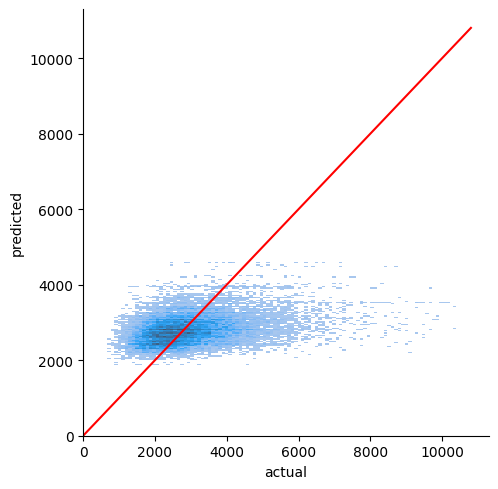

In [30]:
# Plot predicted vs. actual
_ = sns.displot(x = df_pred["actual"],  y = df_pred["preds"])
_ = plt.plot([0, high_end], [0, high_end], c = "red")
_ = plt.xlim(0, high_end + 500)
_ = plt.ylim(0, high_end + 500)
_ = plt.xlabel("actual")
_ = plt.ylabel("predicted")

In [33]:
# Random effects component model summary for GPBoost
gp_model.summary()

Covariance parameters (random effects):
                  Param.
Error_term 925314.594300
store_id   179398.157200


In [34]:
# RE only model summary
re_model.summary()

Model summary:
       Log-lik            AIC            BIC
-734925.020000 1469856.040000 1469884.200000
Nb. observations: 88345
Nb. groups: 5194 (store_id)
-----------------------------------------------------
Covariance parameters (random effects):
                  Param.
Error_term 923242.691800
store_id   168377.528800
-----------------------------------------------------
Linear regression coefficients (fixed effects):
                 Param.
Covariate_1 2842.130600


# Inference

In [ ]:
# Get SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

In [ ]:
# SHAP summary of all features
shap.plots.beeswarm(shap_values)

In [ ]:
shap.plots.bar(shap_values)

In [ ]:
# EXPERIMENTAL: Plot cyclical minute feature's SHAP contributions
shap_sin = shap_values[:, "minute_sin"].values
shap_cos = shap_values[:, "minute_cos"].values
_ = sns.scatterplot(data = X_train, x = "minute_sin", y = "minute_cos", hue = (shap_sin + shap_cos))

# Findings
- Performance worse overall.
- The fixed effects from the booster have virtually no effect on the predictions. The random effect makes a -200 + 200 mean contribution mostly.
- A random effect only model yields the same predictive performance.
- The boosting model parameters make practically zero difference in validation scores. With store_id as a random effect, there may be very little signal left for the booster.
- Is the booster not working properly somehow?